In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import xrft
import cartopy.crs as ccrs
from cmocean import cm
import h5py

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
#print(cluster.job_script())
w = cluster.start_workers(5)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.35:48403 Dashboard: http://10.148.1.35:8787/status,Cluster Workers: 10 Cores: 40 Memory: 500.00 GB


---


# 1. Drifter data files

In [5]:
# The processed data set only includes GPS-tracked surface drifters.
# 2-month blocks with overlapping by 50%

data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
drifter_dataset = h5py.File(data_dir+'Drifter_dataset_processed_GPS.mat','r') 
list(drifter_dataset.items())

# mlat2: mean latitude every 60 days,     25008*1
# mlon2: mean longitude every 60 days,    25008*1

# qd: drogued drifters,                  25008*1
# qu: undrogued drifters,                25008*1
# qmedxxx: median water depth > xxx m,   25008*1

# uv2: (u, v),                           25008*1440

[('dpth2', <HDF5 dataset "dpth2": shape (25008, 1440), type "<f8">),
 ('mdpth', <HDF5 dataset "mdpth": shape (25008, 1), type "<f8">),
 ('mlat2', <HDF5 dataset "mlat2": shape (25008, 1), type "<f8">),
 ('mlon2', <HDF5 dataset "mlon2": shape (25008, 1), type "<f8">),
 ('qall1000', <HDF5 dataset "qall1000": shape (25008, 1), type "|u1">),
 ('qall200', <HDF5 dataset "qall200": shape (25008, 1), type "|u1">),
 ('qall500', <HDF5 dataset "qall500": shape (25008, 1), type "|u1">),
 ('qd', <HDF5 dataset "qd": shape (25008, 1), type "|u1">),
 ('qmed1000', <HDF5 dataset "qmed1000": shape (25008, 1), type "|u1">),
 ('qmed200', <HDF5 dataset "qmed200": shape (25008, 1), type "|u1">),
 ('qmed500', <HDF5 dataset "qmed500": shape (25008, 1), type "|u1">),
 ('qu', <HDF5 dataset "qu": shape (25008, 1), type "|u1">),
 ('uv2', <HDF5 dataset "uv2": shape (25008, 1440), type "|V16">)]

In [6]:
# turn mean-lat into xarray_DataArray
lat2 = drifter_dataset['mlat2']
lat2 = np.array(lat2)
lat = xr.DataArray(lat2, dims=['lat', 'none'])
lat = xr.DataArray.squeeze(lat, dim='none')
lat = np.real(lat).rename('lat')
lat

<xarray.DataArray 'lat' (lat: 25008)>
array([  2.851229,   1.022867,  -1.890194, ..., -37.524563, -37.171366,
       -37.194084])
Dimensions without coordinates: lat

In [7]:
# turn mean-lon into xarray_DataArray
lon2 = drifter_dataset['mlon2']
lon2 = np.array(lon2)
lon = xr.DataArray(lon2, dims=['lon', 'none'])
lon = xr.DataArray.squeeze(lon, dim='none')
lon = np.real(lon).rename('lon')
lon

<xarray.DataArray 'lon' (lon: 25008)>
array([267.180947, 258.853496, 249.391945, ..., 325.844828, 326.138668,
       325.506414])
Dimensions without coordinates: lon

In [8]:
# turn drogued_information into xarray_DataArray
qd = drifter_dataset['qd']
qd = np.array(qd)
qd = xr.DataArray(qd, dims=['qd', 'none'])
qd = xr.DataArray.squeeze(qd, dim='none')
qd = np.real(qd).rename('qd')
qd

<xarray.DataArray 'qd' (qd: 25008)>
array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)
Dimensions without coordinates: qd

In [9]:
# (u,v) --> u+iv
uv = drifter_dataset['uv2'].value.view(np.double).reshape((25008, 1440, 2))
uv_drifters = uv[:,:,0] + 1j*uv[:,:,1]
uv_drifters.shape  # result is (10, 10, 10)
uv_drifters

array([[-0.0203+0.0693j, -0.0073+0.0947j, -0.013 +0.0826j, ...,
        -0.4455+0.0456j, -0.4389+0.0293j, -0.4323+0.0129j],
       [-0.0293+0.0409j, -0.0025+0.007j , -0.0035-0.0133j, ...,
        -0.1953+0.1662j, -0.2239+0.164j , -0.2598+0.16j  ],
       [-0.4256-0.0035j, -0.4265-0.0038j, -0.4234-0.0058j, ...,
        -0.2222+0.0083j, -0.2245+0.009j , -0.2268+0.0098j],
       ...,
       [ 0.3967+0.1554j,  0.4447+0.1624j,  0.4864+0.1736j, ...,
         0.072 +0.2357j,  0.0712+0.2299j,  0.0676+0.2051j],
       [ 0.1061+0.0992j,  0.074 +0.0919j,  0.0629+0.096j , ...,
         0.0589+0.0466j,  0.0513+0.0552j,  0.0395+0.0682j],
       [ 0.0622+0.164j ,  0.0589+0.1348j,  0.0671+0.121j , ...,
        -0.1189+0.0092j, -0.1027-0.0244j, -0.0739-0.0525j]])

In [10]:
# Drifter Dataset (u+iv,lat,lon,time,qd)
ds = xr.Dataset({'uv_drifters': (['lat', 'time'], uv_drifters)},
                
                 coords={'lat': (['lat'], lat),
                         'lon': (['lat'], lon),
                         'time':(['time'], np.arange(1440)*3600),
                         'qd':(['lat'], qd)})
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:      (lat: 25008, time: 1440)
Coordinates:
  * lat          (lat) float64 2.851 1.023 -1.89 23.13 23.05 23.46 24.73 ...
    lon          (lat) float64 267.2 258.9 249.4 320.8 319.6 318.0 318.0 ...
  * time         (time) int64 0 3600 7200 10800 14400 18000 21600 25200 ...
    qd           (lat) uint8 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    uv_drifters  (lat, time) complex128 (-0.0203+0.0693j) (-0.0073+0.0947j) ...

 data size: 0.6 GB


_________
# 2. Rotary spectra of drifter uv

## linear detrend and Hanning window

In [14]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd==1).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)
E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
print(E_uv_blocks)
file_E = data_dir+'E_drifter_uv_qd_blocks_GPS.zarr'
%time E_uv_blocks.to_dataset().to_zarr(file_E, mode='w')  

<xarray.DataArray 'E_uv_blocks' (lat: 25008, freq_time: 1440)>
array([[2.780400e+03, 9.600439e+02, 4.305146e+02, ..., 4.605300e+03,
        3.646889e+03, 9.780958e+03],
       [3.895715e+04, 6.329804e+04, 2.627756e+04, ..., 4.451173e+03,
        7.558851e+03, 5.950510e+03],
       [1.305203e+04, 4.731240e+04, 9.544574e+04, ..., 2.462915e+03,
        1.370842e+04, 1.132019e+04],
       ...,
       [5.604732e+02, 1.958392e+03, 1.060817e+04, ..., 1.412836e+03,
        6.680520e+03, 4.213220e+03],
       [5.788188e+02, 1.951424e+02, 7.569457e+01, ..., 1.316694e+03,
        1.368547e+03, 2.636420e+03],
       [3.798517e+02, 1.845695e+03, 1.399439e+03, ..., 1.352164e+03,
        3.481674e+03, 6.464664e+02]])
Coordinates:
  * lat                (lat) float64 2.851 1.023 -1.89 23.13 23.05 23.46 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 

_________
# 3. Load dataset

In [11]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_uv_qd_blocks_GPS.zarr').chunk({'freq_time': 1440,'lat': 1000}) 
E_uv_blocks = ds.E_uv_blocks
print(ds)

<xarray.Dataset>
Dimensions:            (freq_time: 1440, lat: 25008)
Coordinates:
    freq_cpd           (freq_time) float64 dask.array<shape=(1440,), chunksize=(1440,)>
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 ...
  * lat                (lat) float64 2.851 1.023 -1.89 23.13 23.05 23.46 ...
Data variables:
    E_uv_blocks        (lat, freq_time) float64 dask.array<shape=(25008, 1440), chunksize=(1000, 1440)>


In [12]:
# cyclonic spectra
E_uv_1 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_1 = np.real(E_uv_1).rename('E_uv_1')
E_uv_1 

E_uv_2 = ((E_uv_blocks).where( (E_uv_blocks.lat<0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_2 = E_uv_2.assign_coords(freq_time=E_uv_2.freq_time * -1.) 
E_uv_2 = np.real(E_uv_2).rename('E_uv_2')
E_uv_2 

E_drifter_cycl = (E_uv_1 + E_uv_2)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_cycl = E_drifter_cycl.assign_coords(freq_time=E_drifter_cycl.freq_time * 86400.) 
E_drifter_cycl

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

In [13]:
# anti-cyclonic spectra
E_uv_3 = ((E_uv_blocks).where( (E_uv_blocks.lat<0.) & (E_uv_blocks.freq_time>0.) )).mean(dim=('lat'))   
E_uv_3 = np.real(E_uv_3).rename('E_uv_3') 

E_uv_4 = ((E_uv_blocks).where( (E_uv_blocks.lat>0.) & (E_uv_blocks.freq_time<0.) )).mean(dim=('lat'))   
E_uv_4 = E_uv_4.assign_coords(freq_time=E_uv_4.freq_time * -1.) 
E_uv_4 = np.real(E_uv_4).rename('E_uv_4')
E_uv_4 

E_drifter_anti = (E_uv_3 + E_uv_4)/8.64 #(unit:cm^2 s^-2/cpd)
E_drifter_anti = E_drifter_anti.assign_coords(freq_time=E_drifter_anti.freq_time * 86400.) 
E_drifter_anti

<xarray.DataArray (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07

In [18]:
E_drifter_cycl = np.real(E_drifter_cycl).rename('E_drifter_cycl')
E_drifter_anti = np.real(E_drifter_anti).rename('E_drifter_anti')
E_drifter_globalmean = xr.merge([E_drifter_cycl.to_dataset(),E_drifter_anti.to_dataset()])
print(E_drifter_globalmean)
file_E = data_dir+'E_drifter_qd_globalmean_GPS.zarr'
%time E_drifter_globalmean.to_zarr(file_E, mode='w')  

<xarray.Dataset>
Dimensions:            (freq_time: 1439)
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 1.929e-07
Data variables:
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
CPU times: user 2.28 s, sys: 176 ms, total: 2.45 s
Wall time: 6.84 s


# 4. Plots

In [5]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qd_globalmean_GPS.zarr')
print(ds)
E_drifter_anti_GPS = ds.E_drifter_anti
E_drifter_cycl_GPS = ds.E_drifter_cycl

<xarray.Dataset>
Dimensions:            (freq_time: 1439)
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
Data variables:
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>


Text(0.5,1,'GPS-tracked Drifters')

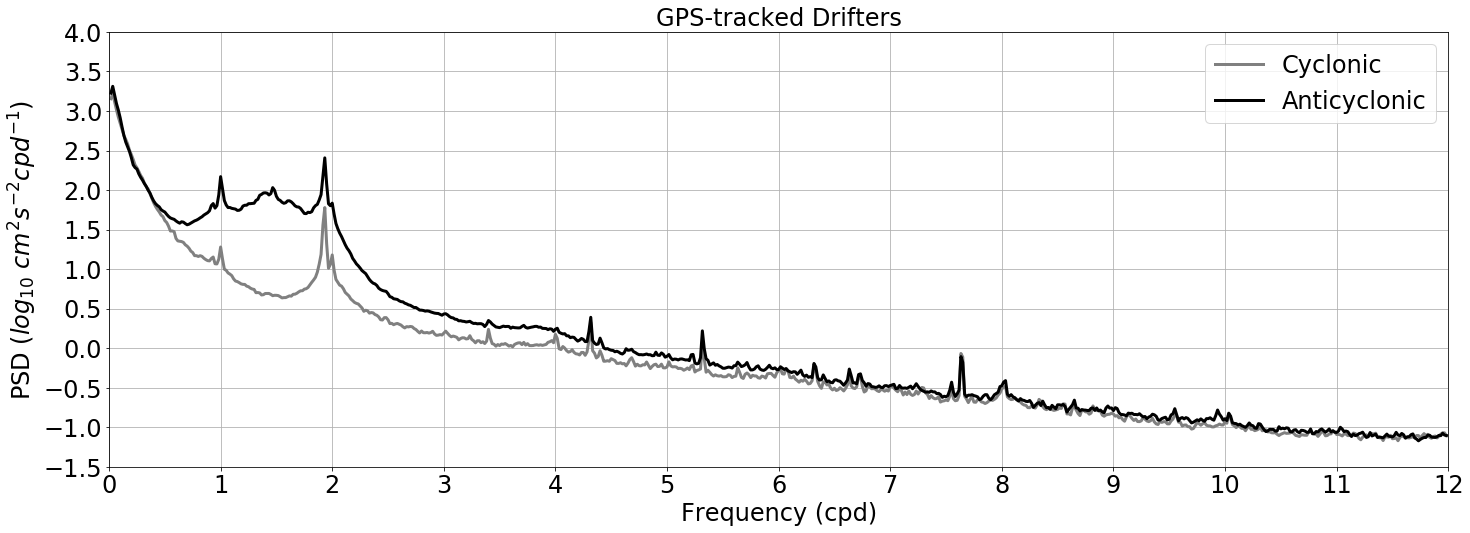

In [6]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

np.log10(E_drifter_cycl_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[0])
np.log10(E_drifter_anti_GPS).plot(ax=ax, linewidth=3, color='black', label=labels[1])

ax.legend(); ax.grid()
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5,-1,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('GPS-tracked Drifters',fontsize=24)


(0.01, 15.0)

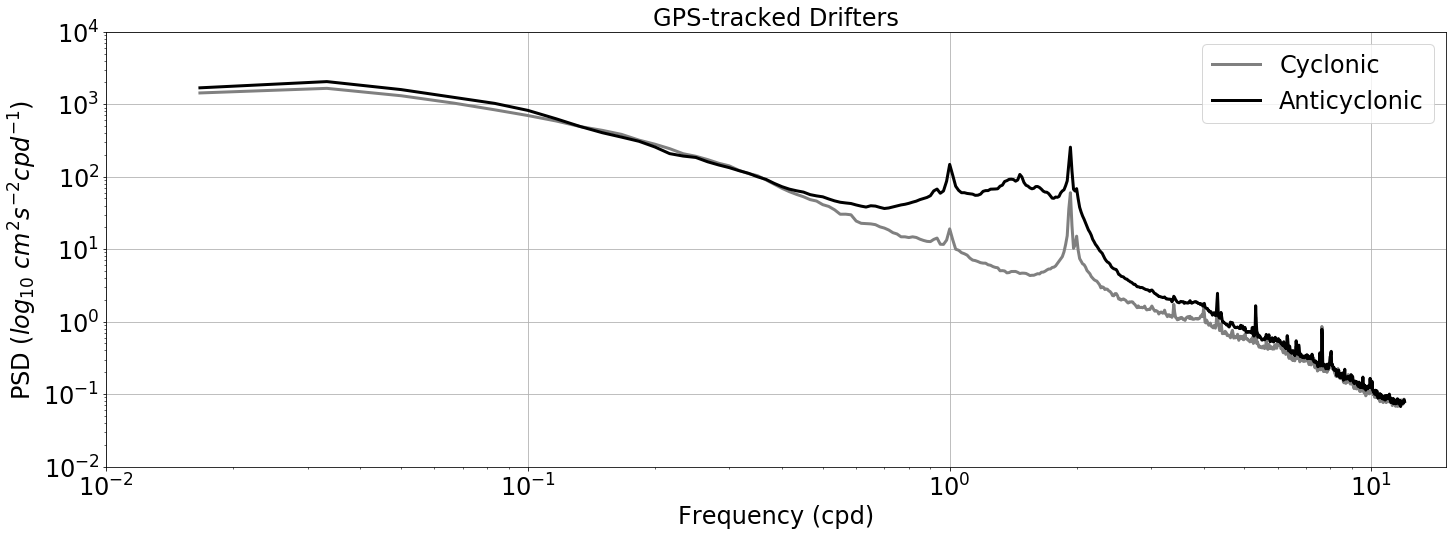

In [7]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic', 'Anticyclonic']

E_drifter_cycl_GPS.plot(ax=ax, linewidth=3, color='grey', label=labels[0])
E_drifter_anti_GPS.plot(ax=ax, linewidth=3, color='black', label=labels[1])

ax.legend(); ax.grid()
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('GPS-tracked Drifters',fontsize=24)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-2,1.5*1e1])

## GPS drifters vs. Argos drifters

In [8]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'
ds = xr.open_zarr(data_dir+'E_drifter_qd_globalmean.zarr')
print(ds)
E_drifter_anti = ds.E_drifter_anti
E_drifter_cycl = ds.E_drifter_cycl

<xarray.Dataset>
Dimensions:            (freq_time: 1439)
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...
Data variables:
    E_drifter_anti     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>
    E_drifter_cycl     (freq_time) float64 dask.array<shape=(1439,), chunksize=(1439,)>


Text(0.5,1,'Drifters')

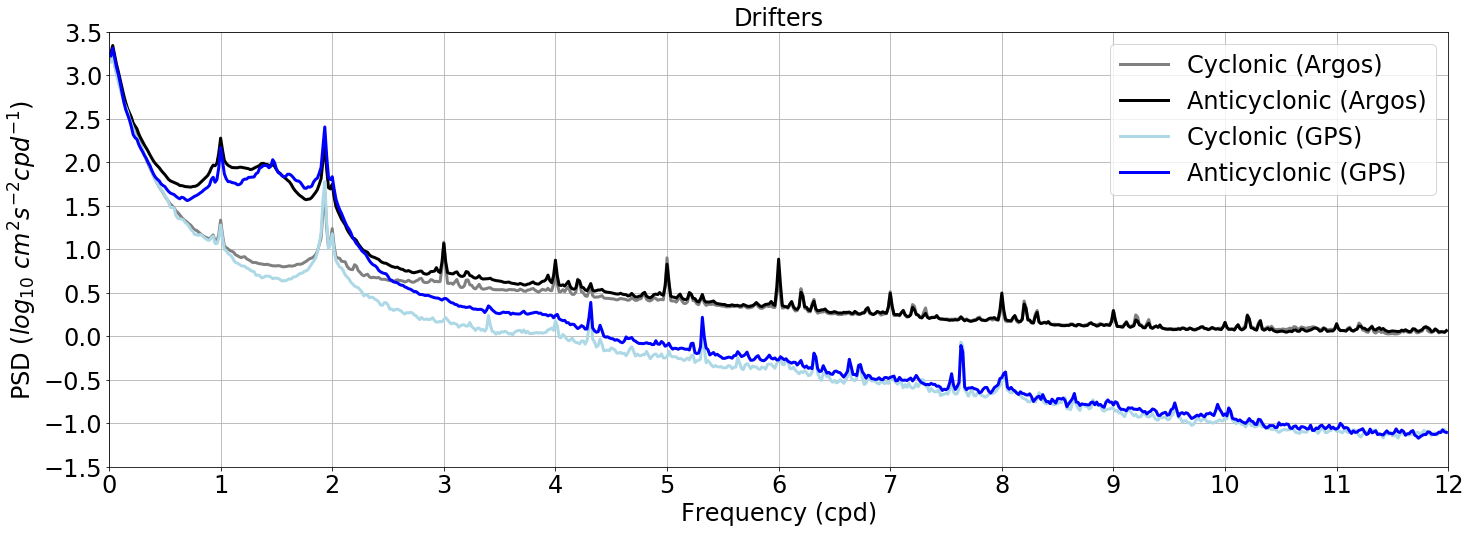

In [9]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic (Argos)', 'Anticyclonic (Argos)', 'Cyclonic (GPS)', 'Anticyclonic (GPS)']

np.log10(E_drifter_cycl).plot(ax=ax, linewidth=3, color='grey', label=labels[0])
np.log10(E_drifter_anti).plot(ax=ax, linewidth=3, color='black', label=labels[1])
np.log10(E_drifter_cycl_GPS).plot(ax=ax, linewidth=3, color='lightblue', label=labels[2])
np.log10(E_drifter_anti_GPS).plot(ax=ax, linewidth=3, color='blue', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.5,3.5])
ax.set_yticks([-1.5,-1,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Drifters',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged.png')

(0.01, 15.0)

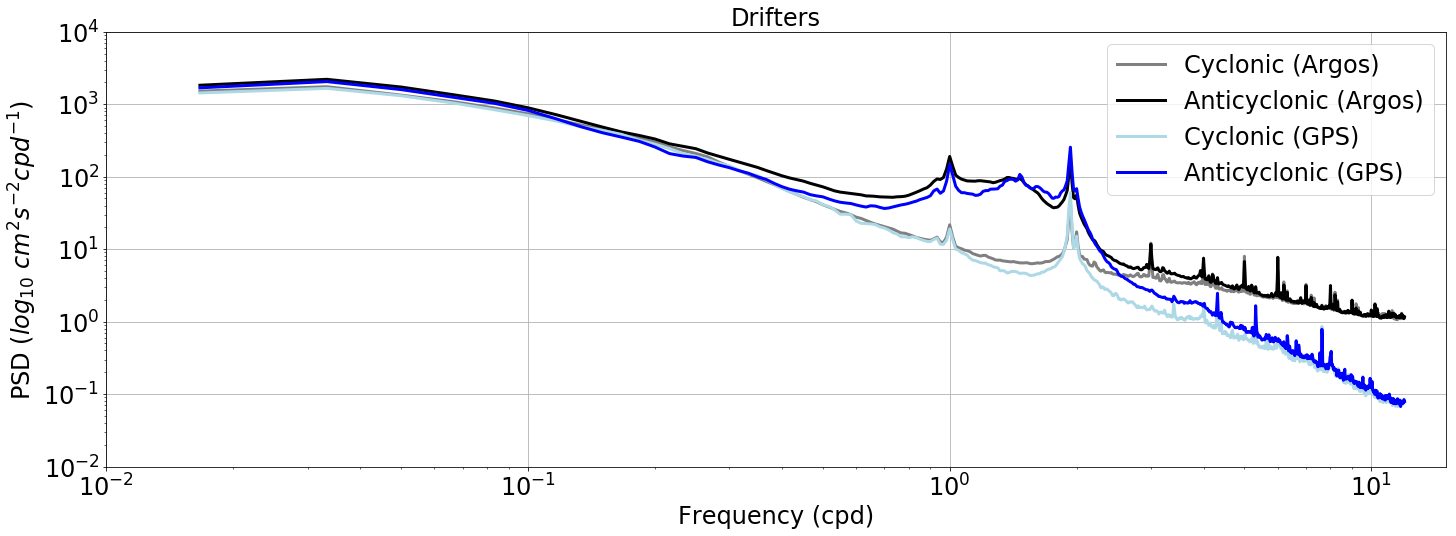

In [10]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Cyclonic (Argos)', 'Anticyclonic (Argos)', 'Cyclonic (GPS)', 'Anticyclonic (GPS)']

E_drifter_cycl.plot(ax=ax, linewidth=3, color='grey', label=labels[0])
E_drifter_anti.plot(ax=ax, linewidth=3, color='black', label=labels[1])
E_drifter_cycl_GPS.plot(ax=ax, linewidth=3, color='lightblue', label=labels[2])
E_drifter_anti_GPS.plot(ax=ax, linewidth=3, color='blue', label=labels[3])

ax.legend(); ax.grid()
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('Drifters',fontsize=24)
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylim([1e-2,1e4])
ax.set_xlim([1e-2,1.5*1e1])

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged.png')

## GPS drifters vs. LLC4320

In [26]:
llc_dir = '/home1/datawork/xyu/LLC4320/mit_zavg_spec/zavg_UV/constant_window/'
ds_llc_cycl = xr.open_zarr(llc_dir+'E_cycl_all_openocean.zarr')
ds_llc_anti = xr.open_zarr(llc_dir+'E_anti_all_openocean.zarr')

E_llc_cycl = ds_llc_cycl.E_cycl_all
E_llc_anti = ds_llc_anti.E_anti_all

Text(0.5,1,'LLC4320 vs. GPS-tracked Drifter')

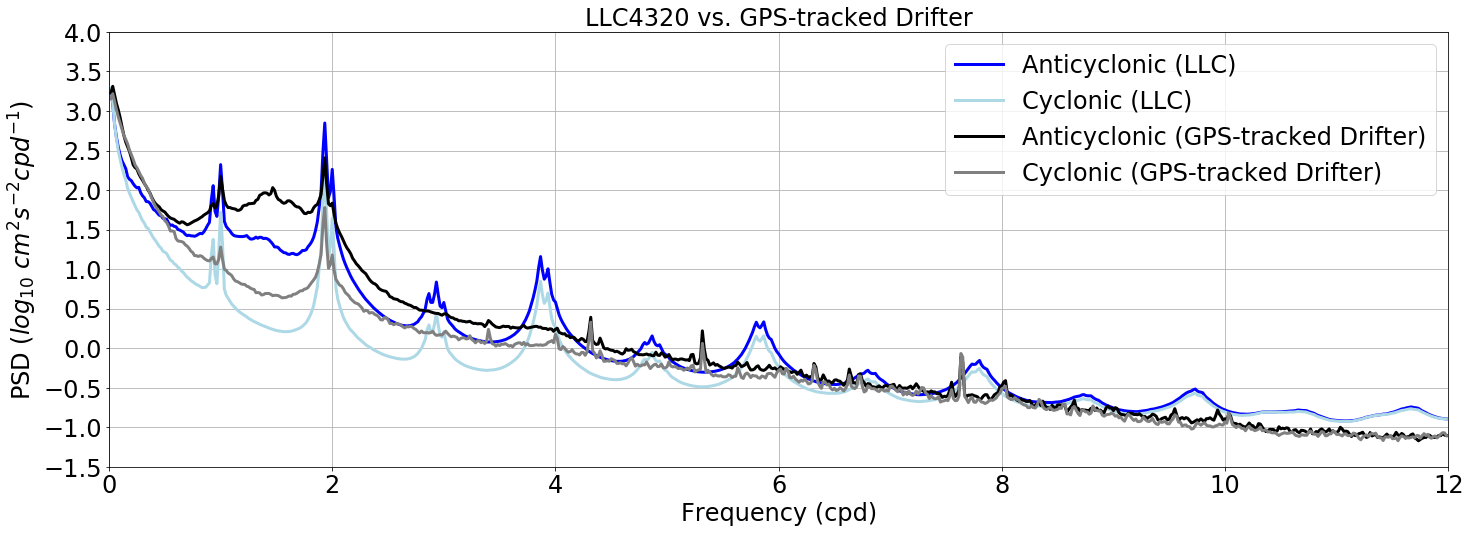

In [13]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Anticyclonic (LLC)', 'Cyclonic (LLC)', 'Anticyclonic (GPS-tracked Drifter)', 'Cyclonic (GPS-tracked Drifter)']
# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_anti_GPS).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_cycl_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5, -1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])

#ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs. GPS-tracked Drifter',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged_comparison.png')

Text(0.5,1,'')

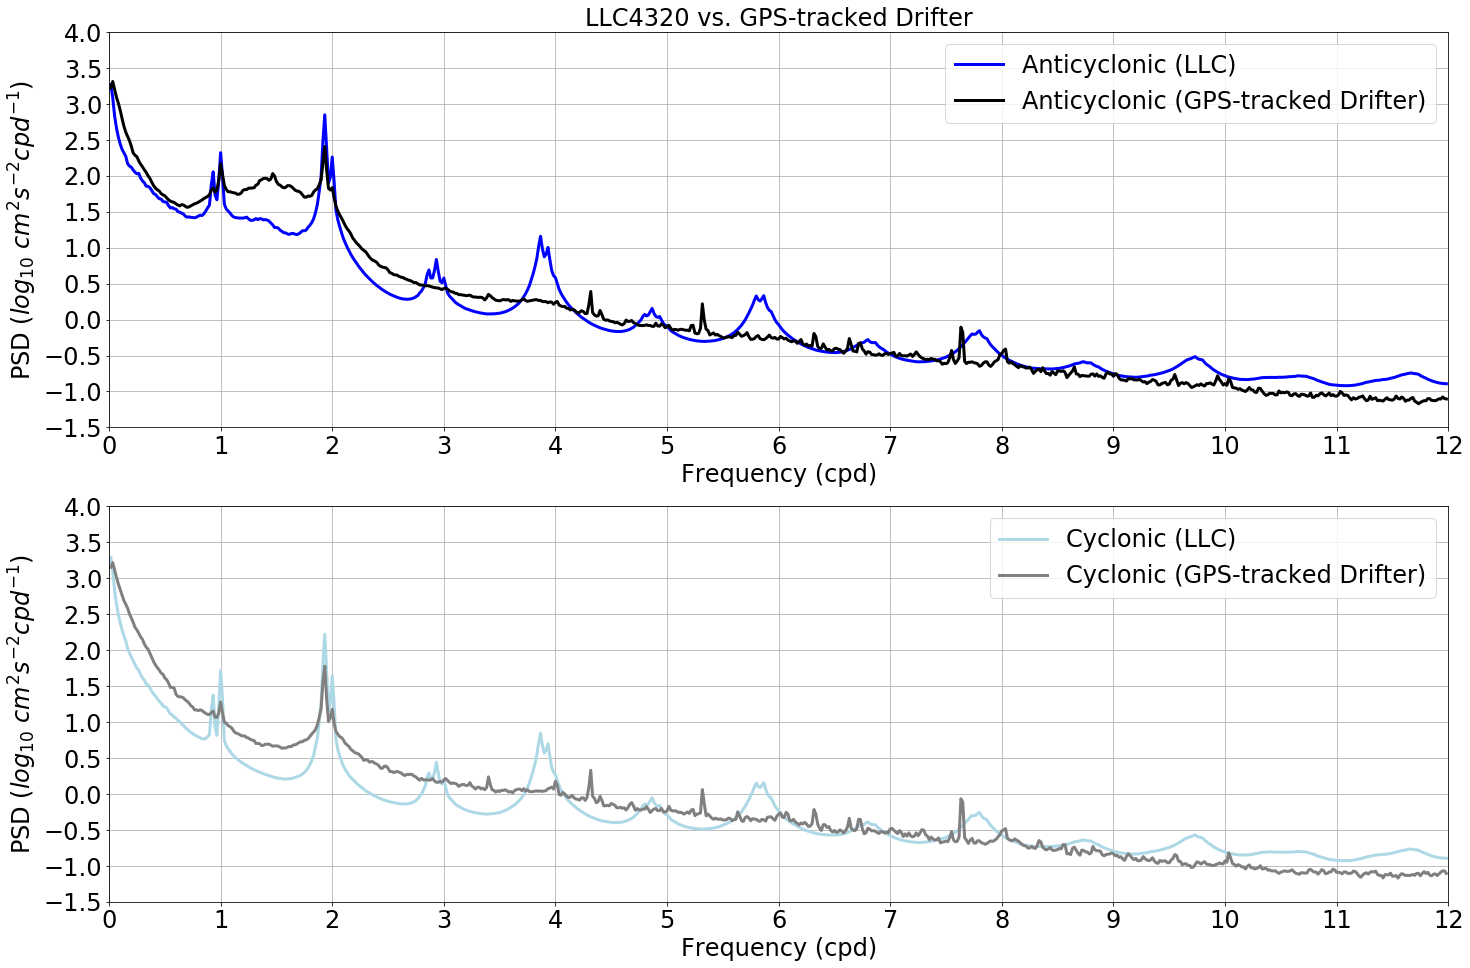

In [19]:
fig, ax = plt.subplots(figsize=(24,16))

labels = ['Anticyclonic (LLC4320)', 'Cyclonic (LLC4320)', 'Anticyclonic (GPS-tracked Drifter)', 'Cyclonic (GPS-tracked Drifter)']

ax = plt.subplot(2,1,1)
# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
# drifter
np.log10(E_drifter_anti_GPS).plot(ax=ax, linewidth=3, color='black', label=labels[2])

ax.legend(); ax.grid()
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5, -1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs. GPS-tracked Drifter',fontsize=24)

ax = plt.subplot(2,1,2)
# llc
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_cycl_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5, -1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([0.,12.])
ax.set_xticks([0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('',fontsize=24)

#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged_comparison.png')

In [27]:
E_llc_anti = E_llc_anti.assign_coords(freq_time=E_llc_anti.freq_time * -1.) 
E_drifter_anti_GPS = E_drifter_anti_GPS.assign_coords(freq_time=E_drifter_anti_GPS.freq_time * -1.) 

In [34]:
E_llc_cycl

<xarray.DataArray 'E_cycl_all' (freq_time: 1439)>
dask.array<shape=(1439,), dtype=float64, chunksize=(1439,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0 0.01667 0.03333 0.05 0.06667 ...
    freq_time_spacing  float64 ...

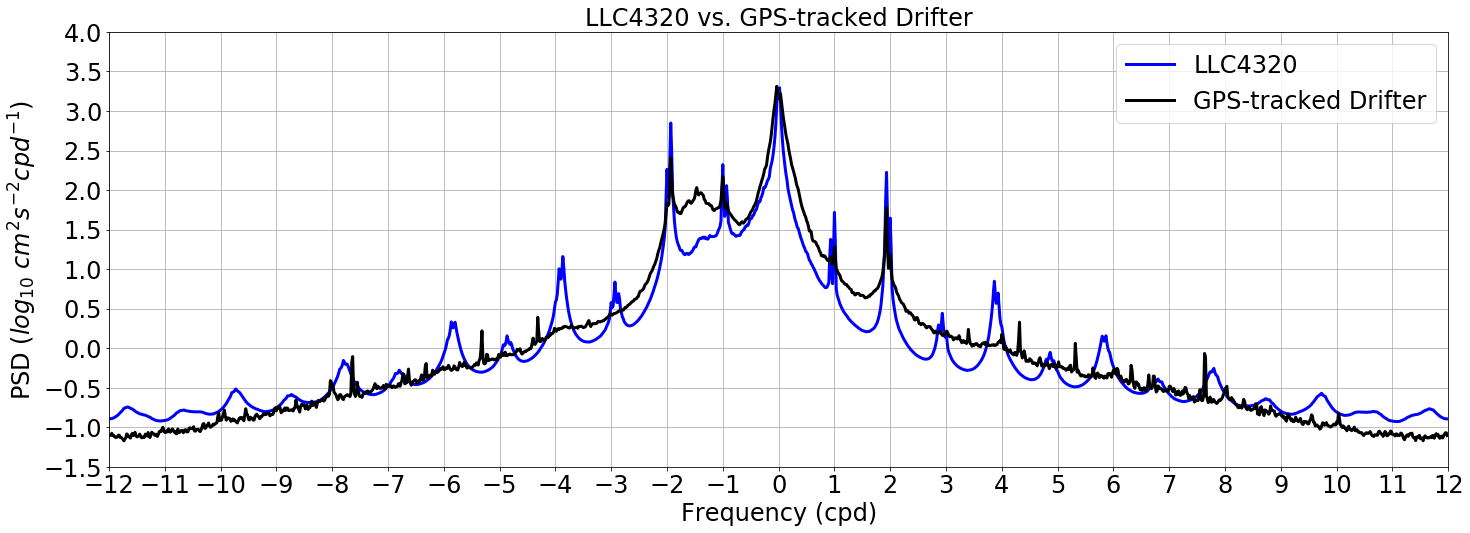

In [37]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['LLC4320', 'GPS-tracked Drifter','']

# llc
np.log10(E_llc_anti).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
np.log10(E_llc_cycl).plot(ax=ax,color='blue', label=labels[2], linewidth=3)
# drifter
np.log10(E_drifter_anti_GPS).plot(ax=ax, linewidth=3, color='black', label=labels[1])
np.log10(E_drifter_cycl_GPS).plot(ax=ax, linewidth=3, color='black', label=labels[2])

ax.legend(); ax.grid()
ax.set_ylim([-1.5,4])
ax.set_yticks([-1.5, -1.,-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5,4.])
ax.set_xlim([-12.,12.])
ax.set_xticks([-12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0., 1., 2., 3., 4., 5., 6., 7., 8., 9., 10., 11., 12.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs. GPS-tracked Drifter',fontsize=24)

plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged_GPS_LLC_comparison.png')

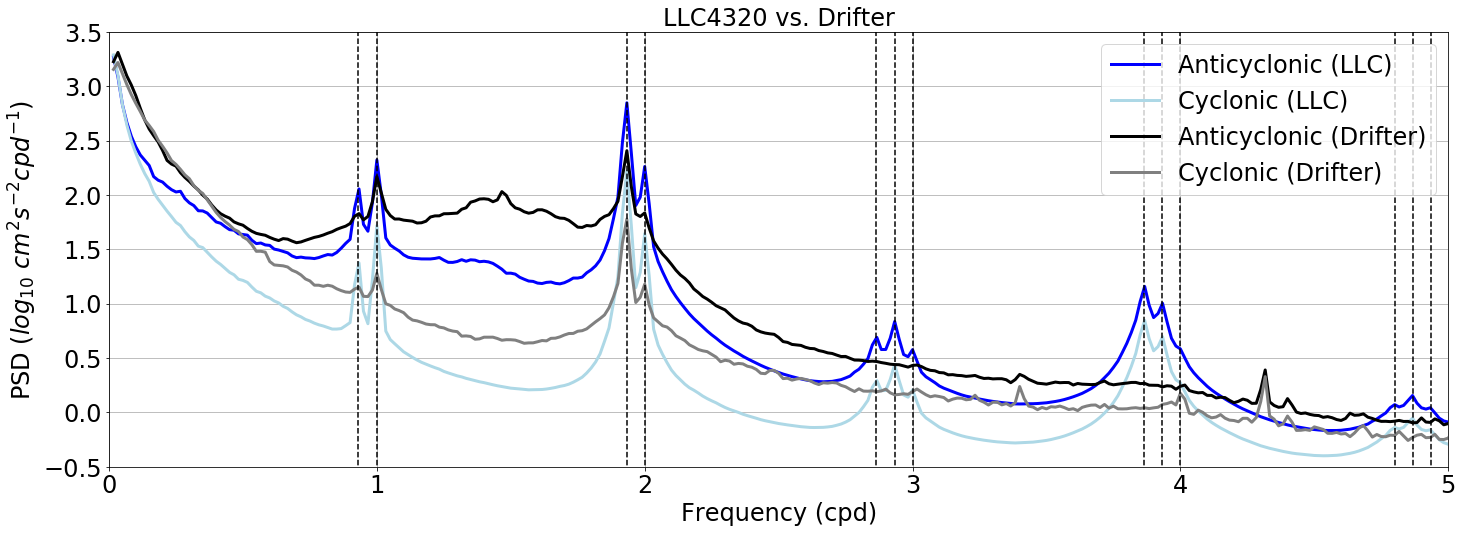

In [15]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Anticyclonic (LLC)', 'Cyclonic (LLC)', 'Anticyclonic (Drifter)', 'Cyclonic (Drifter)']

# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_anti_GPS).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_cycl_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

ax.legend(); ax.grid()
ax.set_ylim([-0.5,3.5])
ax.set_yticks([-0.5, 0., 0.5, 1., 1.5, 2., 2.5, 3., 3.5])
ax.set_xlim([0.,5.])
#ax.set_xticks([0., 1., 2., 3., 4., 5.])
ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs. Drifter',fontsize=24)



# Diurnal frequencies
ax.plot([24/25.81933871,24/25.81933871],[-1,1e6],'k--') # O1
ax.plot([1,1],[-1,1e6],'k--') # S1

# Semi-diurnal frequencies
ax.plot([1.93227,1.93227],[-1,1e6],'k--') # M2
ax.plot([2,2],[-1,1e6],'k--') # S2

# 3
ax.plot([2.86181,2.86181],[-1,1e6],'k--') # MO3
ax.plot([2.93501,2.93501],[-1,1e6],'k--') # MK3
ax.plot([3.00274,3.00274],[-1,1e6],'k--') # SK3

# 4
ax.plot([3.86455,3.86455],[-1,1e6],'k--') # M4
ax.plot([3.93227,3.93227],[-1,1e6],'k--') # MS4
ax.plot([4,4],[-1,1e6],'k--') # S4

# 5
ax.plot([4.79956,4.79956],[-1,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[-1,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[-1,1e6],'k--') # MSK5


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged_comparison_1_5.png')

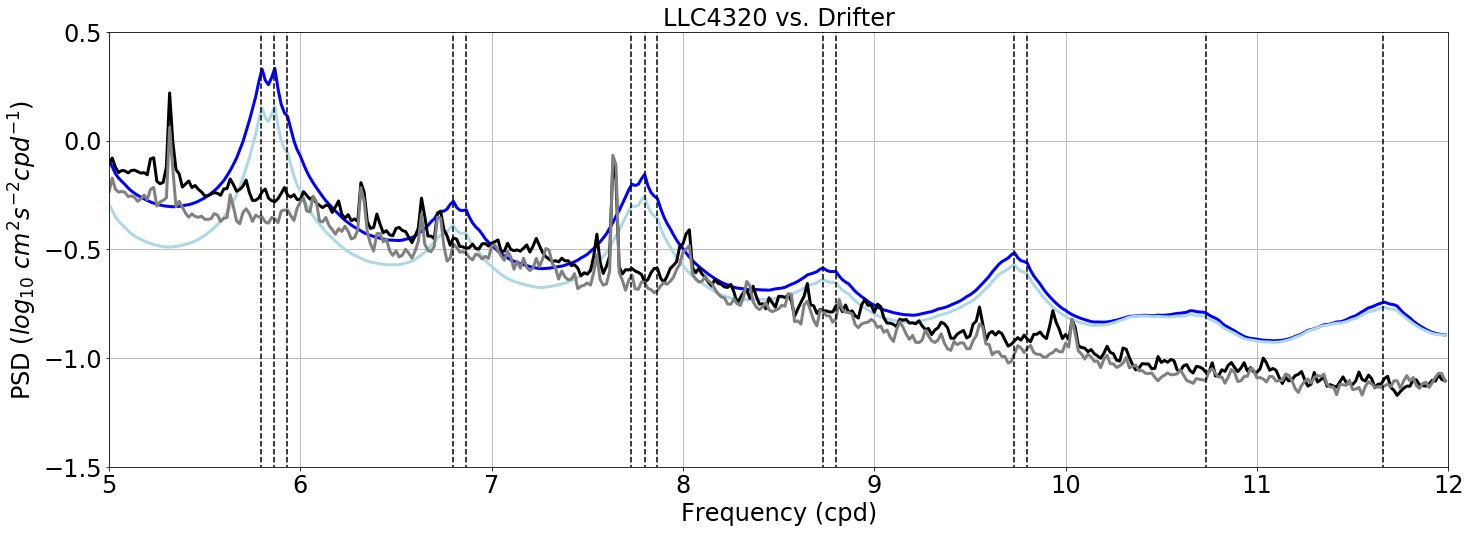

In [16]:
fig, ax = plt.subplots(figsize=(24,8))

labels = ['Anticyclonic (LLC)', 'Cyclonic (LLC)', 'Anticyclonic (Drifter)', 'Cyclonic (Drifter)']

# llc
(np.log10(E_llc_anti).where(E_llc_anti.freq_time>0)).plot(ax=ax,color='blue', label=labels[0], linewidth=3)
(np.log10(E_llc_cycl).where(E_llc_cycl.freq_time>0)).plot(ax=ax,color='lightblue', label=labels[1], linewidth=3)
# drifter
np.log10(E_drifter_anti_GPS).plot(ax=ax, linewidth=3, color='black', label=labels[2])
np.log10(E_drifter_cycl_GPS).plot(ax=ax, linewidth=3, color='grey', label=labels[3])

#ax.legend(); 
ax.grid()
ax.set_ylim([-1.5,0.5])
ax.set_yticks([-1.5,-1.,-0.5, 0., 0.5])
ax.set_xlim([5.,12.])
#ax.set_xticks([5., 6., 7., 8., 9., 10., 11., 12.])
#ax.legend(prop={'size': 24})
ax.set_ylabel('PSD ($log_{10}\ cm^2 s^{-2} cpd^{-1})$',fontsize=24)
ax.set_xlabel('Frequency (cpd)',fontsize=24)
ax.tick_params(labelsize=24)
ax.set_title('LLC4320 vs. Drifter',fontsize=24)



# 5
ax.plot([4.79956,4.79956],[-2,1e6],'k--') # 3MP5
ax.plot([4.86729,4.86729],[-2,1e6],'k--') # 2MK5
ax.plot([4.93501,4.93501],[-2,1e6],'k--') # MSK5

# 6
ax.plot([5.79682,5.79682],[-2,1e6],'k--') # M6
ax.plot([5.86455,5.86455],[-2,1e6],'k--') # 2MS6
ax.plot([5.93227,5.93227],[-2,1e6],'k--') # 2SM6

# 7
ax.plot([6.79956,6.79956],[-2,1e6],'k--') # 3MK7
ax.plot([6.86729,6.86729],[-2,1e6],'k--') # ST17

# 8
ax.plot([7.72909,7.72909],[-2,1e6],'k--') # M8
ax.plot([7.8023,7.8023],[-2,1e6],'k--')   # 3MK8
ax.plot([7.86455,7.86455],[-2,1e6],'k--') # ST23

# 9
ax.plot([8.73183,8.73183],[-2,1e6],'k--') # M4MK9
ax.plot([8.79956,8.79956],[-2,1e6],'k--') # ST27


# 10
ax.plot([9.72909,9.72909],[-2,1e6],'k--') # ST30
ax.plot([9.79682,9.79682],[-2,1e6],'k--') # ST32

# 11
ax.plot([10.7318,10.7318],[-2,1e6],'k--') # ST33


# 12
ax.plot([11.6614,11.6614],[-2,1e6],'k--') # ST34


#plt.savefig('/home1/datahome/xyu/equinox_working/sandbox/Figures/Rotary_spectra_globally_averaged_comparison_5_12.png')

_________
# 2. Rotary spectra of Drifter uv

## raw

In [11]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend=False, window=False, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_raw = E_uv_zonmean
E_drifter_raw = np.real(E_drifter_raw).rename('E_drifter_raw')
file_E = data_dir+'E_drifter_raw_GPS.zarr'
%time E_drifter_raw.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 4.75 s, sys: 320 ms, total: 5.07 s
Wall time: 1.22 s


## linear detrending and Hanning windowing

In [12]:
uv_fft_complex = xrft.dft(ds.uv_drifters.where(ds.qd>0).fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_zonmean = (E_uv_blocks.groupby_bins(E_uv_blocks.lat, np.arange(-60.5, 61, 1), labels=np.arange(-60, 61, 1)).mean(dim=['lat']))

E_drifter_linear_window = E_uv_zonmean#.load()
E_drifter_linear_window = np.real(E_drifter_linear_window).rename('E_drifter_linear_window')
file_E = data_dir+'E_drifter_linear_window_GPS.zarr'
%time E_drifter_linear_window.to_dataset().to_zarr(file_E, mode='w')  

CPU times: user 4.83 s, sys: 304 ms, total: 5.14 s
Wall time: 7.33 s


_________
# 3. Load dataset

In [13]:
data_dir = '/home1/datawork/xyu/Drifters/drifter_data_v1.02/'

ds_raw = xr.open_zarr(data_dir+'E_drifter_raw_GPS.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 
ds_linear_window = xr.open_zarr(data_dir+'E_drifter_linear_window_GPS.zarr').chunk({'freq_time': 1440, 'lat_bins': 1}) 

In [14]:
E_drifter_raw = ds_raw.E_drifter_raw
E_drifter_linear_window = ds_linear_window.E_drifter_linear_window 

In [15]:
df=ds_raw.freq_time[1]-ds_raw.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)
Coordinates:
    freq_time_spacing  float64 1.929e-07


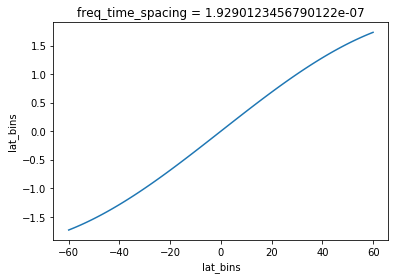

In [16]:
# Inertial frequency
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_drifter_raw.lat_bins))
f_cpd_drifter = f_drifter*86400/2./np.pi
f_cpd_drifter.plot()

Text(0.5,1,'Drifters (linear detrend, window)')

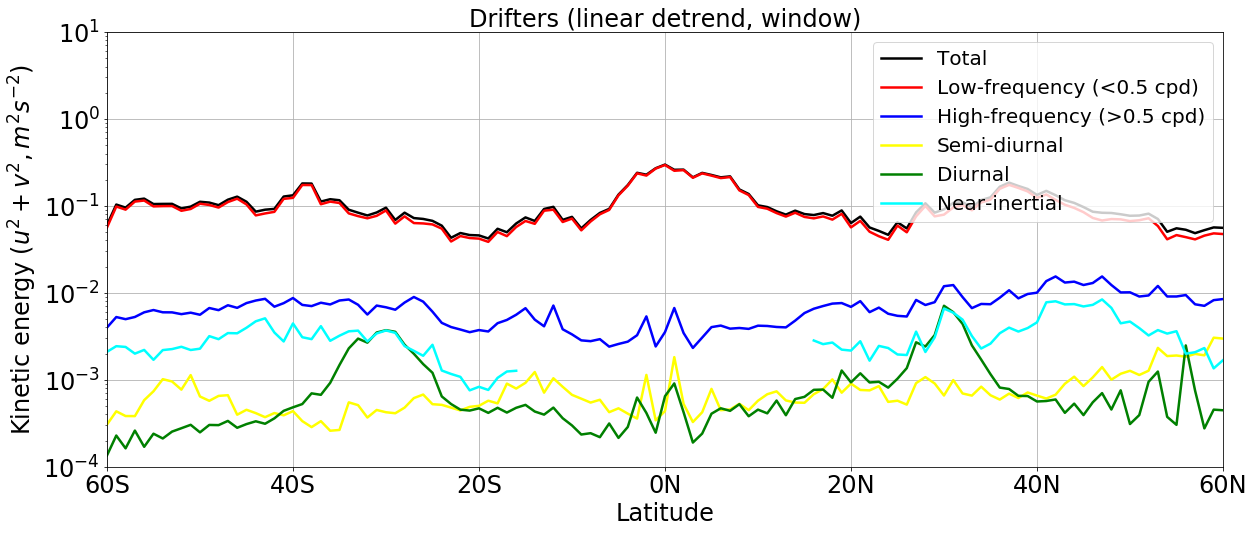

In [17]:
# compare each component by applying windowing

E_drifter = E_drifter_linear_window
E_raw = E_drifter_raw

E_KE_drifter = (E_raw*df).sum(dim='freq_time')
E_high = (E_drifter.where((abs(E_drifter.freq_cpd)>0.5) , other=0.)*df).sum(dim='freq_time')

fig, ax = plt.subplots(figsize=(20,8))

labels = ['Total', 'Low-frequency (<0.5 cpd)','High-frequency (>0.5 cpd)','Semi-diurnal', 'Diurnal', 'Near-inertial']

E_KE_drifter.plot(color='black', label=labels[0], linewidth=2.5) # total energy

(E_KE_drifter - E_high).plot(color='red', label=labels[1], linewidth=2.5) # total energy
E_high.plot(color='blue', label=labels[2], linewidth=2.5)   # energy at low frequencies (> 5 day

(E_drifter.where((abs(E_drifter.freq_cpd)>1.9) & (abs(E_drifter.freq_cpd)<2.1) , other=0.)*df).sum(dim='freq_time').plot(color='yellow', label=labels[3], linewidth=2.5) # energy around semi-diurnal frequencies
(E_drifter.where((abs(E_drifter.freq_cpd)>0.9) & (abs(E_drifter.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time').plot(color='green', label=labels[4], linewidth=2.5) # energy around diurnal frequencies
(E_drifter.where(abs(E_drifter.freq_cpd+f_cpd_drifter)<.1, other=0.)*df).sum(dim='freq_time').where(abs(E_drifter.lat_bins)>15).plot(color='cyan', label=labels[5], linewidth=2.5) # energy around f

ax.legend(prop={'size': 20}); ax.grid()

# x,y ticks
ax.set_xlim(-60., 60.)
ax.set_xticks([-60., -40., -20., 0., 20., 40., 60.])
ax.set_xticklabels(['60S','40S','20S','0N','20N','40N','60N'])
#ax.set_ylim([0,0.4])
ax.set_yscale('log')
ax.set_ylim([1e-4,1e1])
# Label, size
ax.set_xlabel('Latitude',fontsize=24)
ax.set_ylabel('Kinetic energy ($u^2 + v^2, m^2 s^{-2}$)',fontsize=24)
ax.tick_params(labelsize=24)

ax.set_title('Drifters (linear detrend, window)',fontsize=24)

In [18]:
uv_fft_complex = xrft.dft(ds.uv_drifters.fillna(0.), dim=['time'], shift=False, detrend='linear', window=True, chunks_to_segments=False)

E_uv_blocks = (uv_fft_complex*uv_fft_complex.conj()).where(uv_fft_complex!=0., drop=False)/1440*3600
E_uv_blocks = np.real(E_uv_blocks).rename('E_uv_blocks')
E_uv_blocks = E_uv_blocks.assign_coords(freq_cpd=E_uv_blocks.freq_time * 86400.) 
E_uv_blocks = E_uv_blocks.assign_coords(lon=ds.lon) 
print(E_uv_blocks)

<xarray.DataArray 'E_uv_blocks' (lat: 25008, freq_time: 1440)>
array([[2.780400e+03, 9.600439e+02, 4.305146e+02, ..., 4.605300e+03,
        3.646889e+03, 9.780958e+03],
       [3.895715e+04, 6.329804e+04, 2.627756e+04, ..., 4.451173e+03,
        7.558851e+03, 5.950510e+03],
       [1.305203e+04, 4.731240e+04, 9.544574e+04, ..., 2.462915e+03,
        1.370842e+04, 1.132019e+04],
       ...,
       [5.604732e+02, 1.958392e+03, 1.060817e+04, ..., 1.412836e+03,
        6.680520e+03, 4.213220e+03],
       [5.788188e+02, 1.951424e+02, 7.569457e+01, ..., 1.316694e+03,
        1.368547e+03, 2.636420e+03],
       [3.798517e+02, 1.845695e+03, 1.399439e+03, ..., 1.352164e+03,
        3.481674e+03, 6.464664e+02]])
Coordinates:
  * lat                (lat) float64 2.851 1.023 -1.89 23.13 23.05 23.46 ...
  * freq_time          (freq_time) float64 0.0 1.929e-07 3.858e-07 5.787e-07 ...
    freq_time_spacing  float64 1.929e-07
    freq_cpd           (freq_time) float64 0.0 0.01667 0.03333 0.05 0.06667 

In [19]:
df = E_uv_blocks.freq_time[1] - E_uv_blocks.freq_time[0]
print(df)

<xarray.DataArray 'freq_time' ()>
array(1.929012e-07)
Coordinates:
    freq_time_spacing  float64 1.929e-07


In [20]:
f_drifter = 2.*2.*np.pi/86400. * np.sin(np.deg2rad(E_uv_blocks.lat))
f_cpd_drifter = f_drifter*86400/2./np.pi

In [21]:
E_semi = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>1.86) & (abs(E_uv_blocks.freq_cpd)<2.06) , other=0.)*df).sum(dim='freq_time')
E_semi = np.real(E_semi).rename('E_semi')

E_diurnal = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>0.9) & (abs(E_uv_blocks.freq_cpd)<1.1) , other=0.)*df).sum(dim='freq_time')
E_diurnal = np.real(E_diurnal).rename('E_diurnal')

E_high = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd)>=0.5), other=0.)*df).sum(dim='freq_time')
E_high  = np.real(E_high).rename('E_high')

E_f = (E_uv_blocks.where((abs(E_uv_blocks.freq_cpd+f_cpd_drifter)<0.1), other=0.)*df).sum(dim='freq_time')
E_f = np.real(E_f).rename('E_f')

In [22]:
E_drifter = xr.merge([E_semi.to_dataset(), E_diurnal.to_dataset(), E_high.to_dataset(), E_f.to_dataset()])
file_E = data_dir+'E_drifter_GPS.nc'
%time E_drifter.to_netcdf(file_E, mode='w')  

CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 948 ms


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/dask/utils.py:1010: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [40]:
cluster.scheduler.close()

<Future finished result=None>